In [1]:
from sabr import SABR
from sabr_calibration import SABRCalibrator

In [2]:
from deltadex_calibration import calibrate_sabr
from deribit_parser import GetOptionMeta

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


In [4]:
import uniswap_v3_liquidity_math as uniswap_math

import importlib
importlib.reload(uniswap_math)

<module 'uniswap_v3_liquidity_math' from '/Users/kirillbogomolov/Desktop/DeltaDex-Protocol/research-branch-main/backtest/uniswap_v3_liquidity_math.py'>

In [5]:
class UniswapPosition:
    def __init__(self, lower_price, upper_price, initial_price, initial_token1_amount, period_in_years):
        self.lower_price = lower_price
        self.upper_price = upper_price
        self.initial_price = initial_price
        self.initial_token1_amount = initial_token1_amount
        self.period_in_years = period_in_years
    
    def get_tokens_amounts(self, price):
        return uniswap_math.get_tokens_amounts(initial_price = self.initial_price, 
                                lowerPrice = self.lower_price, upperPrice = self.upper_price, 
                                initial_y = self.initial_token1_amount, currentPrice = price)
    
    def get_total_value(self, price):
        x, y = self.get_tokens_amounts(price)
        return x * price + y

In [6]:
uniswap_position = UniswapPosition(lower_price = 1500, 
                                   upper_price = 2000,
                                   initial_price = 1650, 
                                   initial_token1_amount = 300,    # usdcs
                                   period_in_years = 30 / 365.25)

In [7]:
uniswap_position.get_total_value(uniswap_position.initial_price)

891.1688614652894

In [8]:
uniswap_position.get_tokens_amounts(uniswap_position.initial_price)

(0.35828415846381173, 300.0)

## Setting up the SABR model

### Optimal option

In [56]:
class OptimalOption:
    def __init__(self, sabr_model: SABR, 
                 uniswap_position: UniswapPosition):
        
        self.sabr_model = sabr_model
        self.uniswap_position = uniswap_position
        
        self.isCall = False
        # self.expiration = (1.01 * uniswap_position.period_in_years)
        self.expiration = 79 / 365.25
        self.strike = 1700
        # self.strike = (uniswap_position.lower_price * uniswap_position.upper_price) ** 0.5
        self.amount = 0.3
        self.initial_cost = self.amount * self.sabr_model(self.strike, 
                                                self.uniswap_position.initial_price, 
                                                self.expiration, 
                                                self.isCall)[0]
    
    def find_optimal_option(self):
        pass
    
    def calculate_hedged_position(self, prices):
        def calculate_pnl(price):
            if self.isCall == True:
                return max(price - self.strike, 0)
            if self.isCall == False:
                return max(self.strike - price, 0)
        
        option_pnls = self.amount * np.array([calculate_pnl(price) + (self.sabr_model(self.strike, 
                                                    price, 
                                                    (self.expiration - self.uniswap_position.period_in_years), 
                                                    self.isCall)[0] - self.initial_cost) for price in prices])
        return option_pnls
    
    def __repr__(self):
        return ("""
        isCall: {}
        expiration: {}
        strike: {}
        amount: {}
        initial cost: {} 
        ---
        uniswap_position: lower_price: {}, upper_price: {},
        initial_price: {}, period_in_years: {}
        """.format(self.isCall, 
                    self.expiration,
                    self.strike,
                    self.amount,
                    self.initial_cost,
                    self.uniswap_position.lower_price,
                    self.uniswap_position.upper_price,
                    self.uniswap_position.initial_price,
                    self.uniswap_position.period_in_years))
    

### Calibration

In [57]:
OptionMeta = GetOptionMeta()['Expiry']
expiries = list(map(lambda expiry: (expiry[:-5] + "/" + expiry[-5:-2] + "/" + expiry[-2:]), OptionMeta))


In [58]:
expiries

['30/JUN/23',
 '29/DEC/23',
 '10/FEB/23',
 '31/MAR/23',
 '17/FEB/23',
 '24/FEB/23',
 '29/SEP/23',
 '9/FEB/23',
 '28/APR/23',
 '8/FEB/23']

In [59]:
expiry = expiries[-2]
expiry

'28/APR/23'

In [60]:
sabr, underlying_price = calibrate_sabr(SELECTED_EXPIRY = expiry)


/Users/kirillbogomolov/Desktop/DeltaDex-Protocol/research-branch-main/backtest/deribit_parser.py:29: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/kirillbogomolov/Desktop/DeltaDex-Protocol/research-branch-main/backtest/deribit_parser.py:29: RuntimeWarning:

invalid value encountered in double_scalars



db updated 2023-02-07 22:13:51.109674


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 4711.88it/s]

optimized parameters:
('alpha ', 2.29442)
('v ', 0.55738)
('beta  ', 0.82764)
('rho', 0.73519)


In [61]:
# sabr.r = 0.1

In [62]:
# #sabr model parameters
# alpha = 0.2
# v = 0.9
# beta = 0.9
# rho = -0.5

# sabr_params_0 = np.asarray([alpha, v, beta, rho])

In [63]:
r = 0.1
#sabr model
# sabr_0 = SABR(sabr_params_0, r)

In [64]:
optimal_option = OptimalOption(sabr, uniswap_position)

In [65]:
print(optimal_option)


        isCall: False
        expiration: 0.216290212183436
        strike: 1700
        amount: 0.3
        initial cost: 68.40786048074165 
        ---
        uniswap_position: lower_price: 1500, upper_price: 2000,
        initial_price: 1650, period_in_years: 0.08213552361396304
        


In [66]:
prices = np.array([price for price in range(500, 4000, 50 )])

pure_usdc = np.array([optimal_option.initial_cost + 
                      uniswap_position.get_total_value(uniswap_position.initial_price) for _ in prices])

In [67]:
uniswap_tvs = np.array([uniswap_position.get_total_value(price) for price in prices])
option_pnls = optimal_option.calculate_hedged_position(prices)


/Users/kirillbogomolov/Desktop/DeltaDex-Protocol/research-branch-main/backtest/sabr_approx.py:43: RuntimeWarning:

invalid value encountered in double_scalars



In [68]:
# pure_usdc

In [69]:
# uniswap_tvs

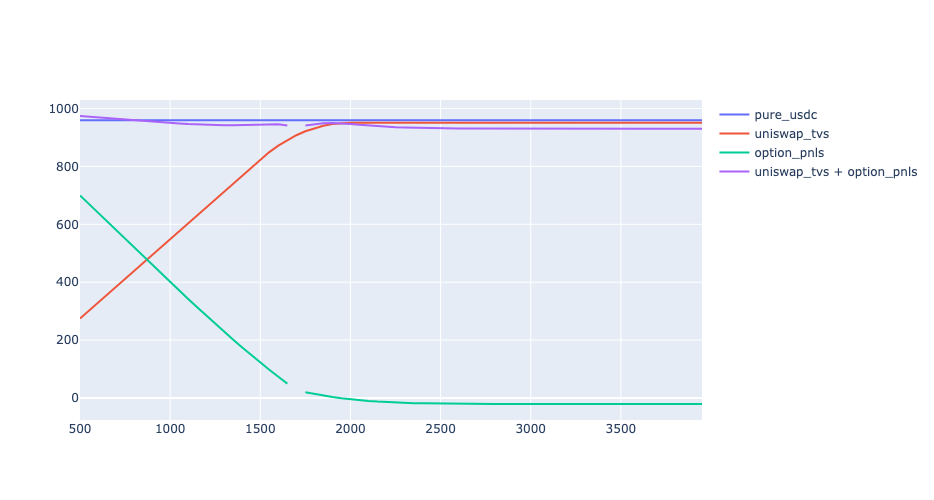

In [70]:
fig = go.Figure()
fig.update_layout(
    autosize=False,
    width=800,
    height=500)

fig.add_trace(go.Scatter(x=prices, y=pure_usdc,
                    mode='lines',
                    name='pure_usdc'))

fig.add_trace(go.Scatter(x=prices, y=uniswap_tvs,
                    mode='lines',
                    name='uniswap_tvs'))
fig.add_trace(go.Scatter(x=prices, y=option_pnls,
                    mode='lines',
                    name='option_pnls'))
fig.add_trace(go.Scatter(x=prices, y=uniswap_tvs + option_pnls,
                    mode='lines',
                    name='uniswap_tvs + option_pnls'))

In [181]:
print(optimal_option)


        isCall: False
        expiration: 0.08295687885010267
        strike: 1732.0508075688772
        amount: 0.3
        initial cost: 24.540218667170564 
        ---
        uniswap_position: lower_price: 1500, upper_price: 2000,
        initial_price: 1650, period_in_years: 0.08213552361396304
        


In [159]:
def plot_smile():
    #strikes
    Kn = F * np.linspace(0.5, 2.6, 32)
    c0, iv0 = sabr_0( Kn, F, T )
    plt.figure(figsize=(15, 8))
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(Kn, c0)
    ax1.grid()
    ax1.set_title("Option price", fontsize=15)
    ax1.set_xlabel("strike", fontsize=12)

    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(Kn, iv0)
    ax2.grid()
    ax2.set_title("IV", fontsize=15)
    ax2.set_xlabel("strike", fontsize=12)

    plt.show()
    None